In [1]:
!python --version

Python 3.11.5


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
P = 850  
E = 120e9  
nu = 0.25

sigma_max_values = np.linspace(10e6, 70e6, 4) 
delta_u_values = np.linspace(0.2e-3, 0.7e-3, 4)  
alpha_values = np.linspace(2, 7, 3)

def damage_non_linear(delta, delta_max, delta_u, alpha):
    if delta <= delta_max:
        return 0
    else:
        return 1 - ((delta_max / delta) * (1 - np.exp(-alpha * (delta - delta_max) / (delta_u - delta_max))))

def traction_linear(delta, sigma_max, delta_max, delta_u, D):
    if delta <= delta_max:
        return sigma_max * (delta / delta_max)
    else:
        return sigma_max * (1 - D)

data = []
for sigma_max in sigma_max_values:
    for delta_u in delta_u_values:
        delta_max = 0.01 * delta_u
        for alpha in alpha_values:
            for delta in np.linspace(0, delta_u, 50): 
                D = damage_non_linear(delta, delta_max, delta_u, alpha)
                T = traction_linear(delta, sigma_max, delta_max, delta_u, D)
                data.append([sigma_max, delta_u, delta_max, alpha, delta, D, T])

columns = ['sigma_max', 'delta_u', 'delta_max', 'alpha', 'delta', 'damage', 'traction']
df = pd.DataFrame(data, columns=columns)

df.to_csv('data.csv', index=False)

df

,sigma_max,delta_u,delta_max,alpha,delta,damage,traction
0,10000000.0,0.0002,0.000002,2.0,0.000000,0.000000,0.000000
1,10000000.0,0.0002,0.000002,2.0,0.000004,0.989805,101954.667112
2,10000000.0,0.0002,0.000002,2.0,0.000008,0.985213,147874.516529
3,10000000.0,0.0002,0.000002,2.0,0.000012,0.983943,160571.997151
4,10000000.0,0.0002,0.000002,2.0,0.000016,0.983496,165042.923358
...,...,...,...,...,...,...,...
2395,70000000.0,0.0007,0.000007,7.0,0.000643,0.989129,760984.294586
2396,70000000.0,0.0007,0.000007,7.0,0.000657,0.989363,744603.884537
2397,70000000.0,0.0007,0.000007,7.0,0.000671,0.989587,728899.112506
2398,70000000.0,0.0007,0.000007,7.0,0.000686,0.989802,713830.566864


In [4]:
x = df[['sigma_max', 'delta_u', 'delta_max', 'alpha', 'delta']]
y = df['damage']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.to_csv('X_train.csv', index=False)
x_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [5]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1920, 5)
y_train shape: (1920,)
x_test shape: (480, 5)
y_test shape: (480,)


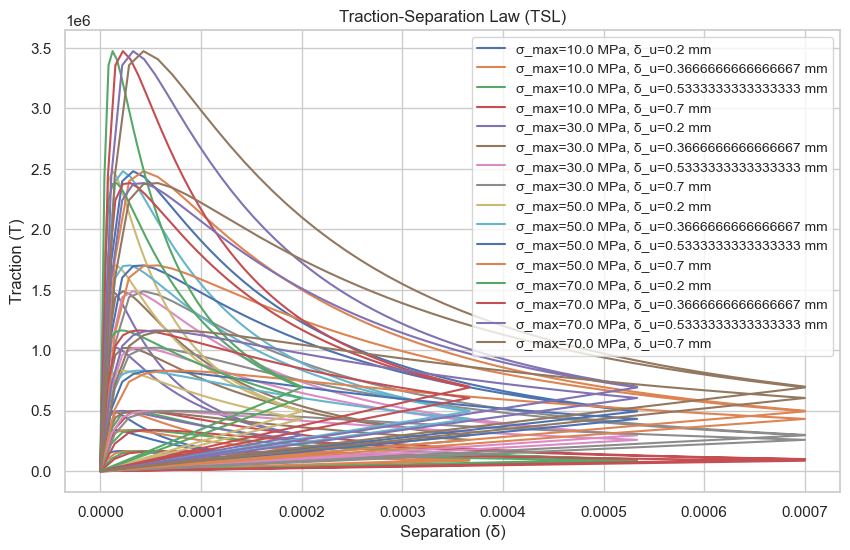

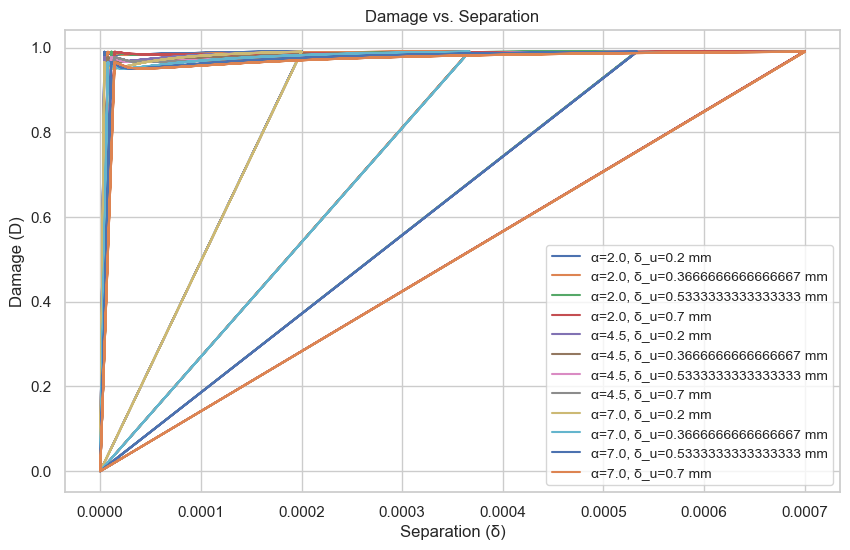

In [6]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
for sigma_max in df['sigma_max'].unique():
    for delta_u in df['delta_u'].unique():
        subset = df[(df['sigma_max'] == sigma_max) & (df['delta_u'] == delta_u)]
        plt.plot(subset['delta'], subset['traction'], label=f'σ_max={sigma_max/1e6} MPa, δ_u={delta_u*1e3} mm')

plt.title('Traction-Separation Law (TSL)')
plt.xlabel('Separation (δ)')
plt.ylabel('Traction (T)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for alpha in df['alpha'].unique():
    for delta_u in df['delta_u'].unique():
        subset = df[(df['alpha'] == alpha) & (df['delta_u'] == delta_u)]
        plt.plot(subset['delta'], subset['damage'], label=f'α={alpha}, δ_u={delta_u*1e3} mm')

plt.title('Damage vs. Separation')
plt.xlabel('Separation (δ)')
plt.ylabel('Damage (D)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

In [7]:
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#learning rate kamtar javab behtar mishe
model1 = MLPRegressor(hidden_layer_sizes=(70, 50, 10), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=100)
model1.fit(x_train, y_train)

train_loss1 = model1.loss_
y_pred1 = model1.predict(x_test)
test_loss1 = np.mean((y_test - y_pred1) ** 2)
test_mae1 = np.mean(np.abs(y_test - y_pred1))

print(f'ANN1 - Train Loss: {train_loss1}')
print(f'ANN1 - Test Loss: {test_loss1}')
print(f'ANN1 - Test MAE: {test_mae1}')


ANN1 - Train Loss: 144.67861018493105
ANN1 - Test Loss: 12.235980331123294
ANN1 - Test MAE: 2.8501206486501305


Epoch 1/100
60/60 [==============================] - 1s 2ms/step - loss: 253163356160.0000 - mae: 251768.1562 - val_loss: 1582970240.0000 - val_mae: 34541.3516
Epoch 2/100
60/60 [==============================] - 0s 956us/step - loss: 155467088.0000 - mae: 7818.0381 - val_loss: 24515.7188 - val_mae: 136.2102
Epoch 3/100
60/60 [==============================] - 0s 917us/step - loss: 357523.1250 - mae: 361.7956 - val_loss: 3282.1384 - val_mae: 49.9599
Epoch 4/100
60/60 [==============================] - 0s 921us/step - loss: 703.9257 - mae: 15.9351 - val_loss: 10.3687 - val_mae: 3.0159
Epoch 5/100
60/60 [==============================] - 0s 933us/step - loss: 1.0826 - mae: 0.7985 - val_loss: 0.3322 - val_mae: 0.4814
Epoch 6/100
60/60 [==============================] - 0s 930us/step - loss: 0.3123 - mae: 0.4592 - val_loss: 0.3289 - val_mae: 0.4768
Epoch 7/100
60/60 [==============================] - 0s 911us/step - loss: 0.3130 - mae: 0.4610 - val_loss: 0.3339 - val_mae: 0.4798
Epoch 8/10

Epoch 62/100
60/60 [==============================] - 0s 877us/step - loss: 0.2906 - mae: 0.4348 - val_loss: 0.2862 - val_mae: 0.4217
Epoch 63/100
60/60 [==============================] - 0s 848us/step - loss: 0.2914 - mae: 0.4355 - val_loss: 0.3190 - val_mae: 0.4615
Epoch 64/100
60/60 [==============================] - 0s 860us/step - loss: 0.2961 - mae: 0.4408 - val_loss: 0.3171 - val_mae: 0.4574
Epoch 65/100
60/60 [==============================] - 0s 848us/step - loss: 0.3000 - mae: 0.4402 - val_loss: 0.3326 - val_mae: 0.4481
Epoch 66/100
60/60 [==============================] - 0s 853us/step - loss: 0.3016 - mae: 0.4440 - val_loss: 0.3022 - val_mae: 0.4745
Epoch 67/100
60/60 [==============================] - 0s 855us/step - loss: 0.3090 - mae: 0.4473 - val_loss: 0.3376 - val_mae: 0.4823
Epoch 68/100
60/60 [==============================] - 0s 849us/step - loss: 0.3202 - mae: 0.4615 - val_loss: 0.3084 - val_mae: 0.4108
Epoch 69/100
60/60 [==============================] - 0s 851us

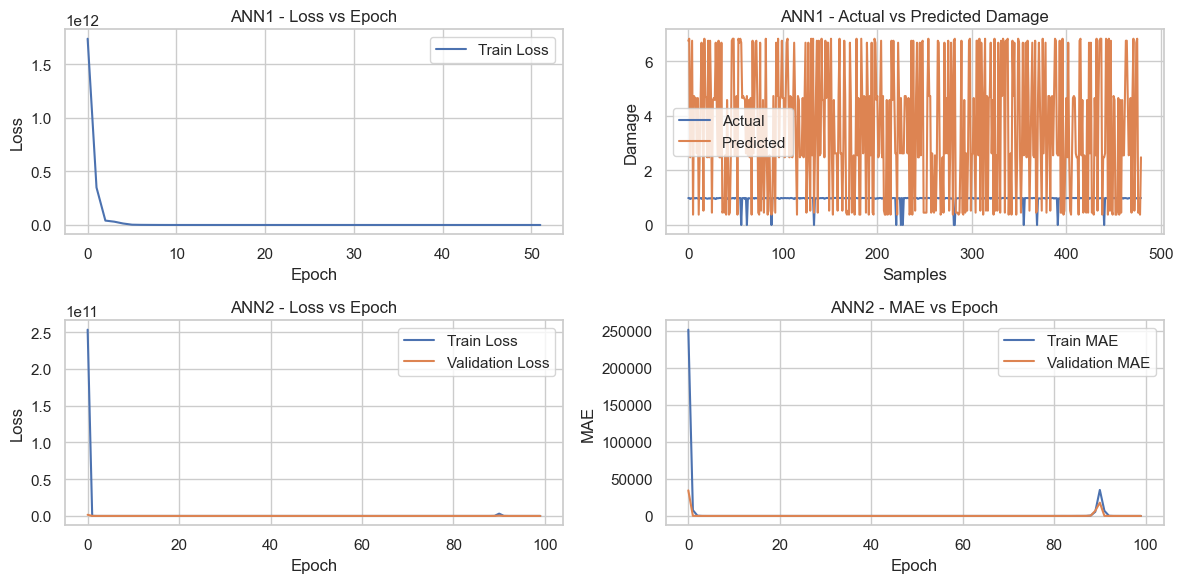

In [8]:
model2 = Sequential()
model2.add(Dense(70, input_dim=x_train.shape[1], activation='relu'))   
model2.add(Dense(50, activation='relu'))  
model2.add(Dense(10, activation='relu'))  
model2.add(Dense(1, activation='linear'))  

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

history = model2.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

loss2, mae2 = model2.evaluate(x_test, y_test)
print(f'ANN2 - Test Loss: {loss2}')
print(f'ANN2 - Test MAE: {mae2}')

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(model1.loss_curve_, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN1 - Loss vs Epoch')

plt.subplot(2, 2, 2)
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred1, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Damage')
plt.legend()
plt.title('ANN1 - Actual vs Predicted Damage')

plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN2 - Loss vs Epoch')

plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('ANN2 - MAE vs Epoch')

plt.tight_layout()
plt.show()

ANN1 - Test Loss: 0.04005010045177907
ANN1 - Test MAE: 0.16589761684759693


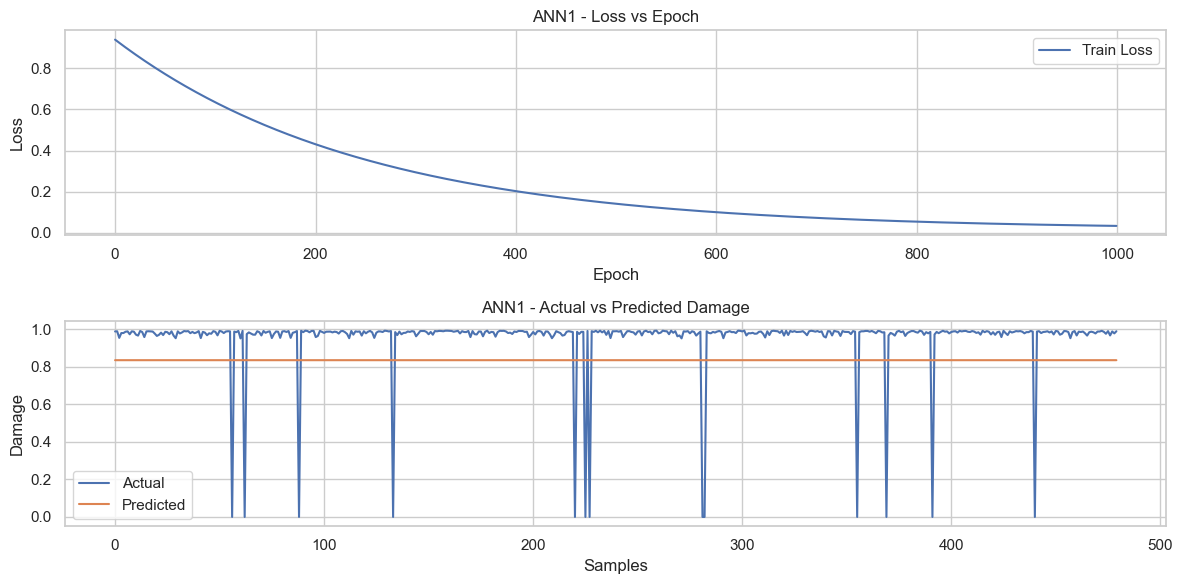

In [9]:

from sklearn.preprocessing import StandardScaler


X = df[['sigma_max', 'delta_u', 'delta_max', 'alpha', 'delta']].values
y = df['damage'].values.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_squared_error_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

input_size = X_train.shape[1]
hidden_layer1_size = 70
hidden_layer2_size = 50
hidden_layer3_size = 10
output_size = 1
learning_rate = 0.001 
epochs = 1000

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_layer1_size) * 0.01
b1 = np.random.randn(hidden_layer1_size) * 0.01
W2 = np.random.randn(hidden_layer1_size, hidden_layer2_size) * 0.01
b2 = np.random.randn(hidden_layer2_size) * 0.01
W3 = np.random.randn(hidden_layer2_size, hidden_layer3_size) * 0.01
b3 = np.random.randn(hidden_layer3_size) * 0.01
W4 = np.random.randn(hidden_layer3_size, output_size) * 0.01
b4 = np.random.randn(output_size) * 0.01

losses = []
for epoch in range(epochs):
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3, W4) + b4
    y_pred = z4
    
    loss = mean_squared_error(y_train, y_pred)
    losses.append(loss)
    
    dL_dy_pred = mean_squared_error_derivative(y_train, y_pred)
    dL_dW4 = np.dot(a3.T, dL_dy_pred)
    dL_db4 = np.sum(dL_dy_pred, axis=0)
    dL_da3 = np.dot(dL_dy_pred, W4.T)
    dL_dz3 = dL_da3 * relu_derivative(z3)
    dL_dW3 = np.dot(a2.T, dL_dz3)
    dL_db3 = np.sum(dL_dz3, axis=0)
    dL_da2 = np.dot(dL_dz3, W3.T)
    dL_dz2 = dL_da2 * relu_derivative(z2)
    dL_dW2 = np.dot(a1.T, dL_dz2)
    dL_db2 = np.sum(dL_dz2, axis=0)
    dL_da1 = np.dot(dL_dz2, W2.T)
    dL_dz1 = dL_da1 * relu_derivative(z1)
    dL_dW1 = np.dot(X_train.T, dL_dz1)
    dL_db1 = np.sum(dL_dz1, axis=0)
    
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2
    W3 -= learning_rate * dL_dW3
    b3 -= learning_rate * dL_db3
    W4 -= learning_rate * dL_dW4
    b4 -= learning_rate * dL_db4

z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = relu(z2)
z3 = np.dot(a2, W3) + b3
a3 = relu(z3)
z4 = np.dot(a3, W4) + b4
y_pred_test = z4

test_loss = mean_squared_error(y_test, y_pred_test)
test_mae = np.mean(np.abs(y_test - y_pred_test))

print(f'ANN1 - Test Loss: {test_loss}')
print(f'ANN1 - Test MAE: {test_mae}')

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN1 - Loss vs Epoch')

plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Damage')
plt.legend()
plt.title('ANN1 - Actual vs Predicted Damage')

plt.tight_layout()
plt.show()

ANN1 - Train Loss: 0.0035680354591752037
ANN1 - Test Loss: 0.03006956729922624
ANN1 - Test MAE: 0.05244376216278973


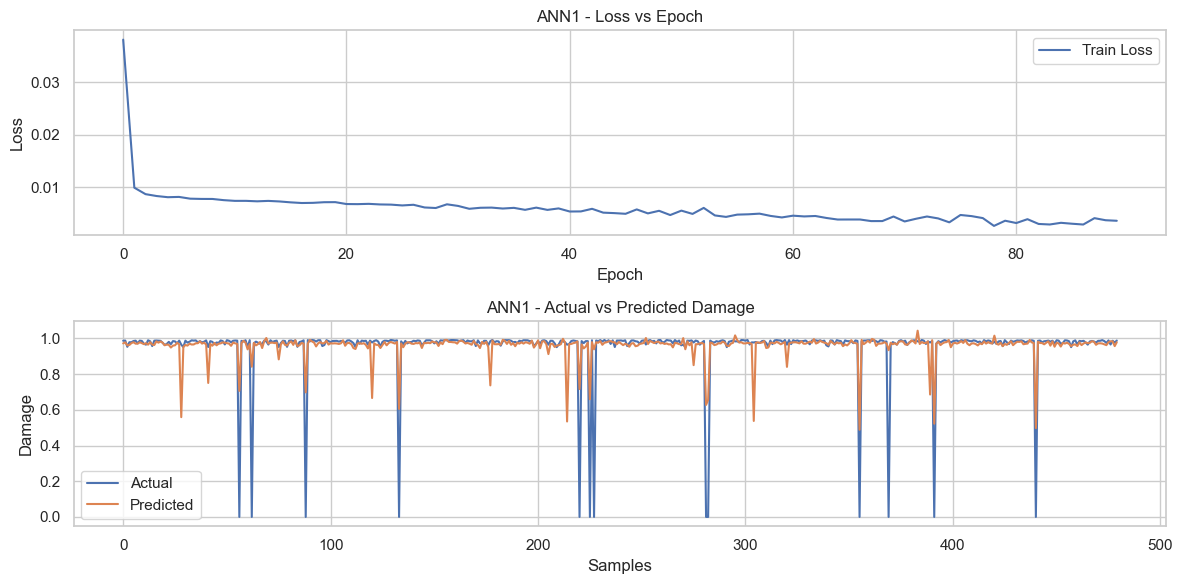

In [12]:



X = df[['sigma_max', 'delta_u', 'delta_max', 'alpha', 'delta']].values
y = df['damage'].values.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = MLPRegressor(hidden_layer_sizes=(100, 50, 25), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=100, batch_size=32, random_state=42)

model1.fit(X_train, y_train.ravel())

train_loss1 = model1.loss_
y_pred1 = model1.predict(X_test)
test_loss1 = np.mean((y_test - y_pred1) ** 2)
test_mae1 = np.mean(np.abs(y_test - y_pred1))

print(f'ANN1 - Train Loss: {train_loss1}')
print(f'ANN1 - Test Loss: {test_loss1}')
print(f'ANN1 - Test MAE: {test_mae1}')

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(model1.loss_curve_, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN1 - Loss vs Epoch')

plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual')
plt.plot(y_pred1, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Damage')
plt.legend()
plt.title('ANN1 - Actual vs Predicted Damage')

plt.tight_layout()
plt.show()